        Metric     Value
0     Accuracy  0.658863
1  Sensitivity  0.597015
2  Specificity  0.709091
3     F1-score  0.610687
Optimal Threshold: 0.5699594020843506


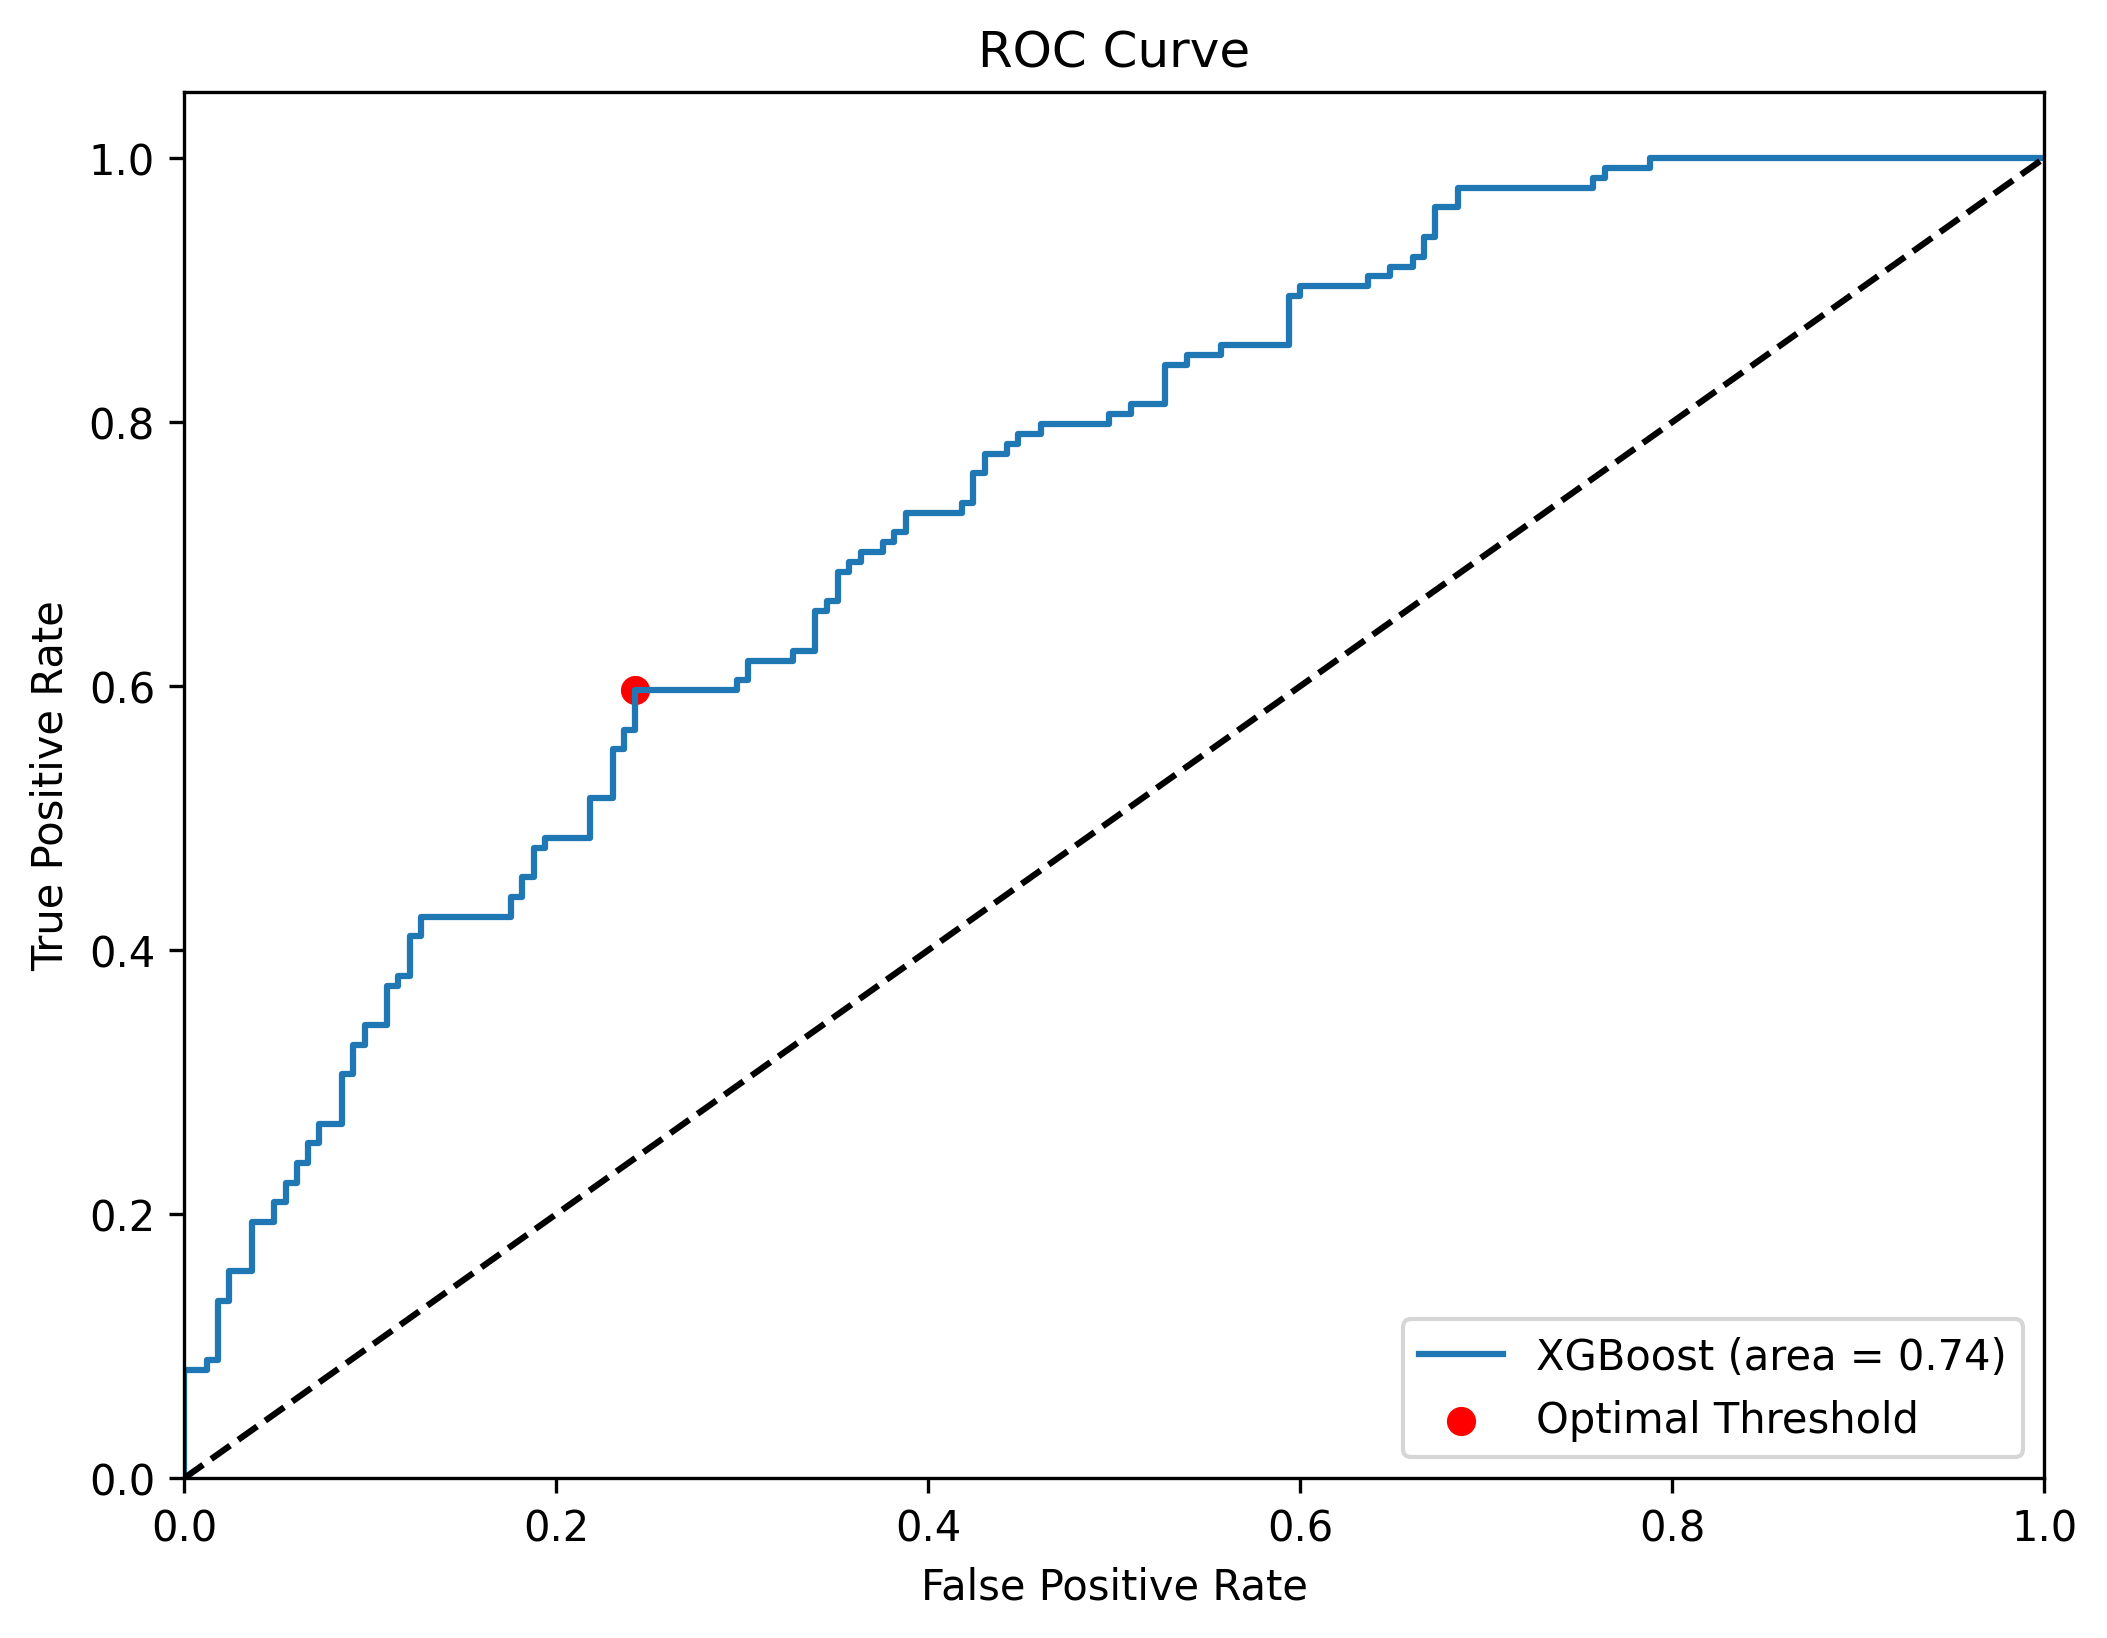

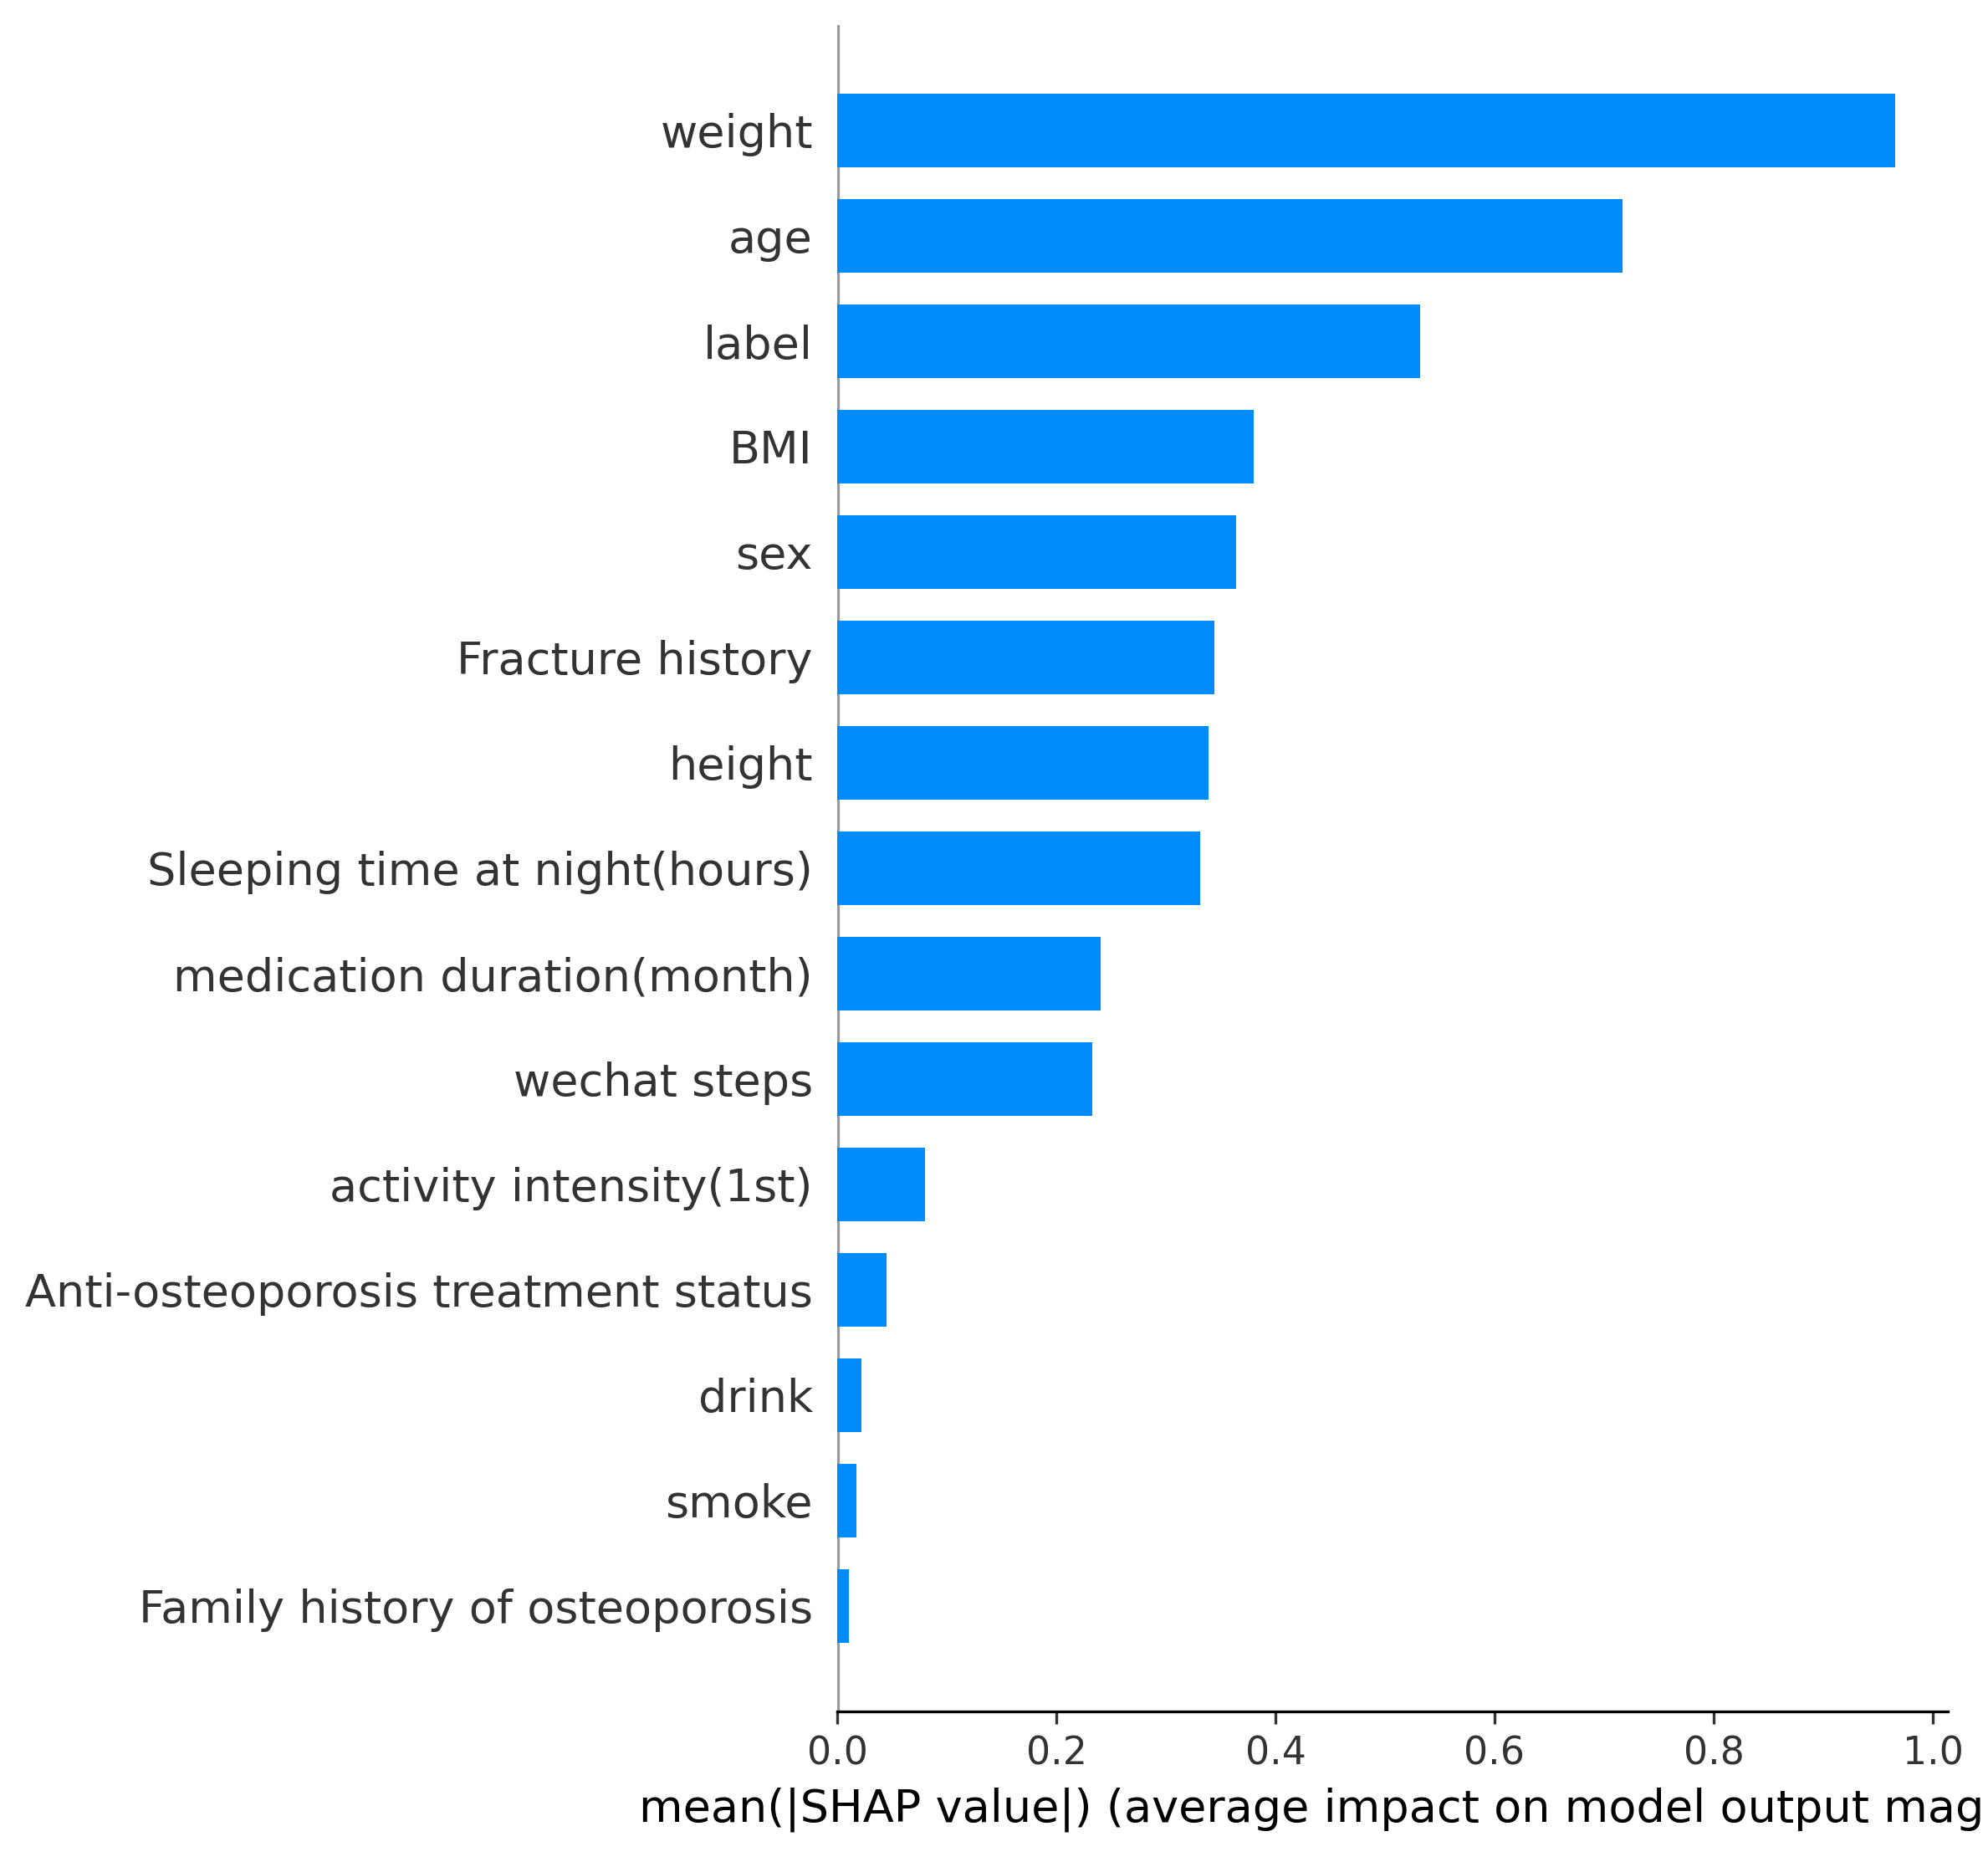

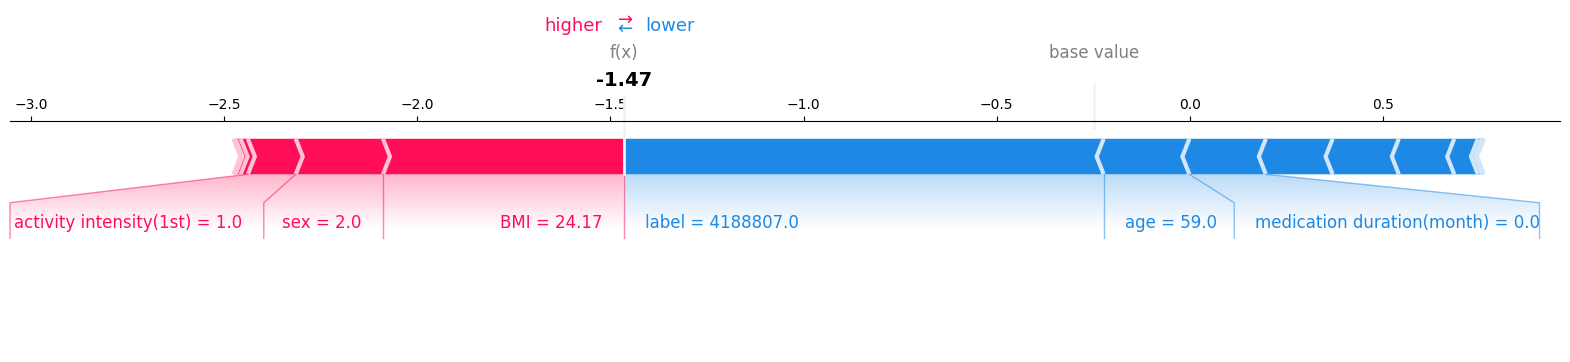

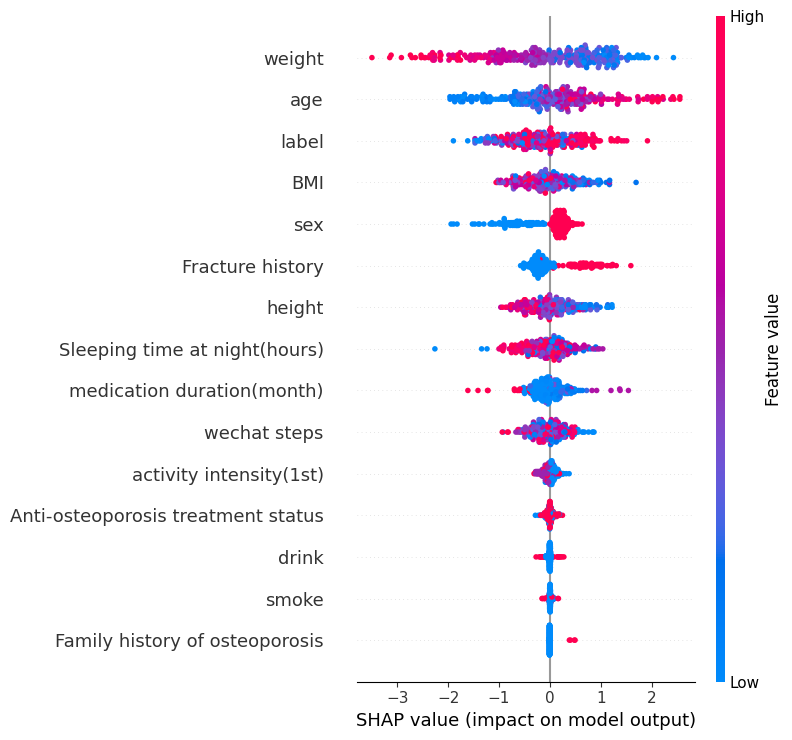

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, f1_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# 加载数据
data = pd.read_csv('analysis.csv')

# 删除Y列中包含缺失值的行
data.dropna(subset=['OA'], inplace=True)  #  确保 'OA' 是你的目标列名

# 分割数据
X = data.drop('OA', axis=1)
y = data['OA']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 训练XGBoost模型
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# 计算评估指标
accuracy = accuracy_score(y_test, y_pred_xgb)
sensitivity = recall_score(y_test, y_pred_xgb)  # 也称为召回率
specificity = recall_score(y_test, y_pred_xgb, pos_label=0)  # 注意pos_label设为0
f1 = f1_score(y_test, y_pred_xgb)

# 构建结果表格
results = pd.DataFrame({
    'Metric': ['Accuracy', 'Sensitivity', 'Specificity', 'F1-score'],
    'Value': [accuracy, sensitivity, specificity, f1]
})
print(results)
# 保存结果表格
results.to_csv('classification_metrics.csv', index=False)

# 绘制ROC曲线
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_proba_xgb)  # 获取阈值
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# 计算Youden指数并找到最佳阈值
youden_index = tpr_xgb - fpr_xgb
optimal_threshold = thresholds_xgb[youden_index.argmax()]
print(f"Optimal Threshold: {optimal_threshold}")

# 设置DPI为300以获得更高分辨率
plt.figure(figsize=(8, 6), dpi=300)  # 修改这里

plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (area = %0.2f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], 'k--')
plt.scatter(fpr_xgb[youden_index.argmax()], tpr_xgb[youden_index.argmax()], marker='o', color='red', label='Optimal Threshold')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# 保存高分辨率图像
plt.savefig('roc_curve_high_res.png', dpi=300)  # 保存为PNG格式
plt.show()

# 计算SHAP值
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# SHAP 可视化也提高分辨率
# 特征重要性
plt.figure(dpi=300)
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)  # show=False 防止立即显示
plt.savefig('shap_feature_importance_high_res.png', bbox_inches='tight', dpi=300)  # 保存图像
plt.show()

# 单个样本force plot
shap.force_plot(explainer.expected_value, shap_values[0, :], X_test.iloc[0, :], matplotlib=True, show=False)  # matplotlib=True 使用matplotlib输出
plt.savefig('shap_force_plot_high_res.png', bbox_inches='tight', dpi=300)
plt.show()

# 汇总所有样本的SHAP值可视化 (提高分辨率)
shap.summary_plot(shap_values, X_test, show=False)
plt.savefig('shap_summary_plot_high_res.png', bbox_inches='tight', dpi=300)
plt.show()